In [ ]:
%pip install super-gradients
%pip install torch
%pip install supervision
%pip install roboflow
%pip install onemetric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.5/684.5 kB 39.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 95.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 105.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.6/408.6 kB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 97.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 8.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build whe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.7/58.7 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.5 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 2.4.5
    Uninstalling pyparsing-2.4.5:
      Successfully uninstalled pyparsing-2.4.5
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.8.0.76
    Uninstalling opencv-python-headless-4.8.0.76:
      Successfully uninstalled 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 3.6 MB/s eta 0:00:00


In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="OZmt7veKofDCRjgyQ5XE")
project = rf.workspace("csilab").project("csilab-braintumor-detection")
dataset = project.version(2).download("yolov8")



loading Roboflow workspace...
loading Roboflow project...
[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics==8.0.134`, to intall it `pip install ultralytics==8.0.134`.



Extracting Dataset Version Zip to CsiLab-BrainTumor-Detection-2 in yolov8:: 100%|██████████| 1356/1356 [00:00<00:00, 7843.16it/s]


In [ ]:
import torch
from super_gradients.training import Trainer

DEVICE = 'cuda' if torch.cuda.is_available() else "cpu"
MODEL_ARCH = 'yolo_nas_l'
BATCH_SIZE = 8
MAX_EPOCHS = 15
CHECKPOINT_DIR = './checkpoints'
EXPERIMENT_NAME = project.name.lower().replace(" ", "_")

from super_gradients.training import Trainer

trainer = Trainer(experiment_name=EXPERIMENT_NAME, ckpt_root_dir=CHECKPOINT_DIR)

LOCATION = dataset.location
CLASSES = sorted(project.classes.keys())

dataset_params = {
    'data_dir': LOCATION,
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'valid/images',
    'val_labels_dir':'valid/labels',
    'test_images_dir':'test/images',
    'test_labels_dir':'test/labels',
    'classes': CLASSES
}
print(dataset_params['classes'])


[2023-09-20 15:08:51] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


[2023-09-20 15:08:52] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-09-20 15:09:00] INFO - utils.py - NumExpr defaulting to 2 threads.
Setuptools is replacing distutils.
[2023-09-20 15:09:04] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-09-20 15:09:04] WARNING - export.py - Failed to import pytorch_quantization
[2023-09-20 15:09:04] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2023-09-20 15:09:05] WARNING - env_sanity_check.py - Failed to verify installed packages: boto3 required but not found
[2023-09-20 15:09:05] WARNING - env_sanity_check.py - Failed to verify installed packages: deprecated required but not found
[2023-09-20 15:09:05] WARNING - env_sanity_check.py - Failed to verify installed packages: coverage required but not found
[2023-09-20 15:09:05] WARNING - env_sanity_check.py - Failed to verify installed packages: sphinx-rtd-theme required but not found
[2023-09-20 15:09:05] WARNING - env_s

In [ ]:
from super_gradients.training.dataloaders.dataloaders import (coco_detection_yolo_format_train, coco_detection_yolo_format_val)

train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': 1
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': 1
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': 2
    }
)

['Tumor']


[2023-09-20 15:09:05] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 582/582 [00:00<00:00, 2306.19it/s]
[2023-09-20 15:09:06] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 60/60 [00:00<00:00, 1483.52it/s]
[2023-09-20 15:09:07] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.


In [ ]:
from super_gradients.training import models

model = models.get(
    MODEL_ARCH,
    num_classes=len(dataset_params['classes']),
    pretrained_weights="coco"
)

Indexing dataset annotations: 100%|██████████| 30/30 [00:00<00:00, 1410.18it/s]
[2023-09-20 15:09:09] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_l_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_l_coco.pth
100%|██████████| 256M/256M [00:00<00:00, 287MB/s]
[2023-09-20 15:09:12] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_l


In [ ]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

train_params = {
    'silent_mode': False,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": MAX_EPOCHS,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

In [ ]:
trainer.train(
    model=model,
    training_params=train_params,
    train_loader=train_data,
    valid_loader=val_data
)

The console stream is now moved to ./checkpoints/csilab-braintumor-detection/console_Sep20_15_09_19.txt


[2023-09-20 15:09:19] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
[2023-09-20 15:09:21] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 582        (len(train_set))
    - Batch size per GPU:           8          (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             8          (num_gpus * batch_size)
    - Effective Batch size:         8          (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         72         (len(train_loader))
    - Gradient updates per epoch:   72         (len(train_loader) / batch_accumulate)

[2023-09-20 15:09:21] INFO - sg_trainer.py - Started training for 15 epochs (0/14)

Validating: 100%|██████████| 8/8 [00:03<00:00,  2.63it/s]
[2023-09-20 15:10:47] INFO - base_sg_logger.py - 

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 2.2025
│   ├── Ppyoloeloss/loss_iou = 0.2587
│   ├── Ppyoloeloss/loss_dfl = 1.541
│   └── Ppyoloeloss/loss = 3.6198
└── Validation
    ├── Ppyoloeloss/loss_cls = 2.5421
    ├── Ppyoloeloss/loss_iou = 0.1738
    ├── Ppyoloeloss/loss_dfl = 1.2074
    ├── Ppyoloeloss/loss = 3.5804
    ├── Precision@0.50 = 0.0
    ├── Recall@0.50 = 0.0
    ├── Map@0.50 = 0.0208
    └── F1@0.50 = 0.0



Validating epoch 1: 100%|██████████| 8/8 [00:02<00:00,  2.69it/s]
[2023-09-20 15:12:04] INFO - base_sg_logger.py - Checkpoint saved in ./checkpoints/csilab-braintumor-detection/ckpt_best.pth
[2023-09-20 15:12:04] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8110278248786926


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1738
│   │   ├── Epoch N-1      = 2.2025 (↘ -1.0286)
│   │   └── Best until now = 2.2025 (↘ -1.0286)
│   ├── Ppyoloeloss/loss_iou = 0.1984
│   │   ├── Epoch N-1      = 0.2587 (↘ -0.0603)
│   │   └── Best until now = 0.2587 (↘ -0.0603)
│   ├── Ppyoloeloss/loss_dfl = 1.2126
│   │   ├── Epoch N-1      = 1.541  (↘ -0.3284)
│   │   └── Best until now = 1.541  (↘ -0.3284)
│   └── Ppyoloeloss/loss = 2.2762
│       ├── Epoch N-1      = 3.6198 (↘ -1.3435)
│       └── Best until now = 3.6198 (↘ -1.3435)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2552
    │   ├── Epoch N-1      = 2.5421 (↘ -1.2869)
    │   └── Best until now = 2.5421 (↘ -1.2869)
    ├── Ppyoloeloss/loss_iou = 0.1624
    │   ├── Epoch N-1      = 0.1738 (↘ -0.0114)
    │   └── Best until now = 0.1738 (↘ -0.0114)
    ├── Ppyoloeloss/loss_dfl = 1.1398
    │   ├── Epoch N-1      = 1.2074 (↘ -0.0676)
    │   └── Best until now = 1.2074 (↘ -0.0676)
    ├── Ppyoloeloss/lo

Validating epoch 2: 100%|██████████| 8/8 [00:02<00:00,  2.68it/s]
[2023-09-20 15:13:23] INFO - base_sg_logger.py - Checkpoint saved in ./checkpoints/csilab-braintumor-detection/ckpt_best.pth
[2023-09-20 15:13:23] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8229222297668457


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0439
│   │   ├── Epoch N-1      = 1.1738 (↘ -0.1299)
│   │   └── Best until now = 1.1738 (↘ -0.1299)
│   ├── Ppyoloeloss/loss_iou = 0.1977
│   │   ├── Epoch N-1      = 0.1984 (↘ -0.0008)
│   │   └── Best until now = 0.1984 (↘ -0.0008)
│   ├── Ppyoloeloss/loss_dfl = 1.2155
│   │   ├── Epoch N-1      = 1.2126 (↗ 0.0029)
│   │   └── Best until now = 1.2126 (↗ 0.0029)
│   └── Ppyoloeloss/loss = 2.1459
│       ├── Epoch N-1      = 2.2762 (↘ -0.1304)
│       └── Best until now = 2.2762 (↘ -0.1304)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.5493
    │   ├── Epoch N-1      = 1.2552 (↗ 0.2941)
    │   └── Best until now = 1.2552 (↗ 0.2941)
    ├── Ppyoloeloss/loss_iou = 0.1574
    │   ├── Epoch N-1      = 0.1624 (↘ -0.005)
    │   └── Best until now = 0.1624 (↘ -0.005)
    ├── Ppyoloeloss/loss_dfl = 1.1444
    │   ├── Epoch N-1      = 1.1398 (↗ 0.0046)
    │   └── Best until now = 1.1398 (↗ 0.0046)
    ├── Ppyoloeloss/loss = 2.5

Validating epoch 3: 100%|██████████| 8/8 [00:03<00:00,  2.64it/s]


SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0295
│   │   ├── Epoch N-1      = 1.0439 (↘ -0.0144)
│   │   └── Best until now = 1.0439 (↘ -0.0144)
│   ├── Ppyoloeloss/loss_iou = 0.207
│   │   ├── Epoch N-1      = 0.1977 (↗ 0.0093)
│   │   └── Best until now = 0.1977 (↗ 0.0093)
│   ├── Ppyoloeloss/loss_dfl = 1.2585
│   │   ├── Epoch N-1      = 1.2155 (↗ 0.043)
│   │   └── Best until now = 1.2126 (↗ 0.0459)
│   └── Ppyoloeloss/loss = 2.1761
│       ├── Epoch N-1      = 2.1459 (↗ 0.0303)
│       └── Best until now = 2.1459 (↗ 0.0303)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.4397
    │   ├── Epoch N-1      = 1.5493 (↘ -0.1095)
    │   └── Best until now = 1.2552 (↗ 0.1845)
    ├── Ppyoloeloss/loss_iou = 0.1657
    │   ├── Epoch N-1      = 0.1574 (↗ 0.0084)
    │   └── Best until now = 0.1574 (↗ 0.0084)
    ├── Ppyoloeloss/loss_dfl = 1.1572
    │   ├── Epoch N-1      = 1.1444 (↗ 0.0129)
    │   └── Best until now = 1.1398 (↗ 0.0174)
    ├── Ppyoloeloss/loss = 2.4327
 

Validating epoch 4: 100%|██████████| 8/8 [00:03<00:00,  2.65it/s]
[2023-09-20 15:16:30] INFO - base_sg_logger.py - Checkpoint saved in ./checkpoints/csilab-braintumor-detection/ckpt_best.pth
[2023-09-20 15:16:30] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8812288045883179


SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9656
│   │   ├── Epoch N-1      = 1.0295 (↘ -0.0638)
│   │   └── Best until now = 1.0295 (↘ -0.0638)
│   ├── Ppyoloeloss/loss_iou = 0.1987
│   │   ├── Epoch N-1      = 0.207  (↘ -0.0082)
│   │   └── Best until now = 0.1977 (↗ 0.001)
│   ├── Ppyoloeloss/loss_dfl = 1.2263
│   │   ├── Epoch N-1      = 1.2585 (↘ -0.0323)
│   │   └── Best until now = 1.2126 (↗ 0.0137)
│   └── Ppyoloeloss/loss = 2.0756
│       ├── Epoch N-1      = 2.1761 (↘ -0.1005)
│       └── Best until now = 2.1459 (↘ -0.0703)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8565
    │   ├── Epoch N-1      = 1.4397 (↘ -0.5832)
    │   └── Best until now = 1.2552 (↘ -0.3987)
    ├── Ppyoloeloss/loss_iou = 0.169
    │   ├── Epoch N-1      = 0.1657 (↗ 0.0032)
    │   └── Best until now = 0.1574 (↗ 0.0116)
    ├── Ppyoloeloss/loss_dfl = 1.1464
    │   ├── Epoch N-1      = 1.1572 (↘ -0.0108)
    │   └── Best until now = 1.1398 (↗ 0.0066)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 5: 100%|██████████| 8/8 [00:03<00:00,  2.56it/s]
[2023-09-20 15:18:25] INFO - base_sg_logger.py - Checkpoint saved in ./checkpoints/csilab-braintumor-detection/ckpt_best.pth
[2023-09-20 15:18:25] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8930771350860596


SUMMARY OF EPOCH 5
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9563
│   │   ├── Epoch N-1      = 0.9656 (↘ -0.0093)
│   │   └── Best until now = 0.9656 (↘ -0.0093)
│   ├── Ppyoloeloss/loss_iou = 0.1972
│   │   ├── Epoch N-1      = 0.1987 (↘ -0.0015)
│   │   └── Best until now = 0.1977 (↘ -0.0005)
│   ├── Ppyoloeloss/loss_dfl = 1.2292
│   │   ├── Epoch N-1      = 1.2263 (↗ 0.003)
│   │   └── Best until now = 1.2126 (↗ 0.0166)
│   └── Ppyoloeloss/loss = 2.064
│       ├── Epoch N-1      = 2.0756 (↘ -0.0116)
│       └── Best until now = 2.0756 (↘ -0.0116)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8213
    │   ├── Epoch N-1      = 0.8565 (↘ -0.0352)
    │   └── Best until now = 0.8565 (↘ -0.0352)
    ├── Ppyoloeloss/loss_iou = 0.1783
    │   ├── Epoch N-1      = 0.169  (↗ 0.0094)
    │   └── Best until now = 0.1574 (↗ 0.0209)
    ├── Ppyoloeloss/loss_dfl = 1.2273
    │   ├── Epoch N-1      = 1.1464 (↗ 0.0809)
    │   └── Best until now = 1.1398 (↗ 0.0875)
    ├── Ppyoloeloss/loss = 1.8

Validating epoch 6: 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]
[2023-09-20 15:20:17] INFO - base_sg_logger.py - Checkpoint saved in ./checkpoints/csilab-braintumor-detection/ckpt_best.pth
[2023-09-20 15:20:17] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9312329292297363


SUMMARY OF EPOCH 6
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9308
│   │   ├── Epoch N-1      = 0.9563 (↘ -0.0255)
│   │   └── Best until now = 0.9563 (↘ -0.0255)
│   ├── Ppyoloeloss/loss_iou = 0.1938
│   │   ├── Epoch N-1      = 0.1972 (↘ -0.0035)
│   │   └── Best until now = 0.1972 (↘ -0.0035)
│   ├── Ppyoloeloss/loss_dfl = 1.2269
│   │   ├── Epoch N-1      = 1.2292 (↘ -0.0024)
│   │   └── Best until now = 1.2126 (↗ 0.0143)
│   └── Ppyoloeloss/loss = 2.0286
│       ├── Epoch N-1      = 2.064  (↘ -0.0354)
│       └── Best until now = 2.064  (↘ -0.0354)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7852
    │   ├── Epoch N-1      = 0.8213 (↘ -0.0361)
    │   └── Best until now = 0.8213 (↘ -0.0361)
    ├── Ppyoloeloss/loss_iou = 0.1625
    │   ├── Epoch N-1      = 0.1783 (↘ -0.0159)
    │   └── Best until now = 0.1574 (↗ 0.0051)
    ├── Ppyoloeloss/loss_dfl = 1.1241
    │   ├── Epoch N-1      = 1.2273 (↘ -0.1032)
    │   └── Best until now = 1.1398 (↘ -0.0157)
    ├── Ppyoloeloss/loss

Validating epoch 7: 100%|██████████| 8/8 [00:03<00:00,  2.41it/s]


SUMMARY OF EPOCH 7
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9208
│   │   ├── Epoch N-1      = 0.9308 (↘ -0.01)
│   │   └── Best until now = 0.9308 (↘ -0.01)
│   ├── Ppyoloeloss/loss_iou = 0.1951
│   │   ├── Epoch N-1      = 0.1938 (↗ 0.0013)
│   │   └── Best until now = 0.1938 (↗ 0.0013)
│   ├── Ppyoloeloss/loss_dfl = 1.2349
│   │   ├── Epoch N-1      = 1.2269 (↗ 0.008)
│   │   └── Best until now = 1.2126 (↗ 0.0223)
│   └── Ppyoloeloss/loss = 2.0258
│       ├── Epoch N-1      = 2.0286 (↘ -0.0028)
│       └── Best until now = 2.0286 (↘ -0.0028)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0244
    │   ├── Epoch N-1      = 0.7852 (↗ 0.2391)
    │   └── Best until now = 0.7852 (↗ 0.2391)
    ├── Ppyoloeloss/loss_iou = 0.1695
    │   ├── Epoch N-1      = 0.1625 (↗ 0.007)
    │   └── Best until now = 0.1574 (↗ 0.0121)
    ├── Ppyoloeloss/loss_dfl = 1.2183
    │   ├── Epoch N-1      = 1.1241 (↗ 0.0942)
    │   └── Best until now = 1.1241 (↗ 0.0942)
    ├── Ppyoloeloss/loss = 2.0572
    

Validating epoch 8: 100%|██████████| 8/8 [00:03<00:00,  2.58it/s]


SUMMARY OF EPOCH 8
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9124
│   │   ├── Epoch N-1      = 0.9208 (↘ -0.0084)
│   │   └── Best until now = 0.9208 (↘ -0.0084)
│   ├── Ppyoloeloss/loss_iou = 0.1865
│   │   ├── Epoch N-1      = 0.1951 (↘ -0.0086)
│   │   └── Best until now = 0.1938 (↘ -0.0073)
│   ├── Ppyoloeloss/loss_dfl = 1.1829
│   │   ├── Epoch N-1      = 1.2349 (↘ -0.0519)
│   │   └── Best until now = 1.2126 (↘ -0.0296)
│   └── Ppyoloeloss/loss = 1.9701
│       ├── Epoch N-1      = 2.0258 (↘ -0.0557)
│       └── Best until now = 2.0258 (↘ -0.0557)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7217
    │   ├── Epoch N-1      = 1.0244 (↘ -0.3027)
    │   └── Best until now = 0.7852 (↘ -0.0636)
    ├── Ppyoloeloss/loss_iou = 0.1682
    │   ├── Epoch N-1      = 0.1695 (↘ -0.0013)
    │   └── Best until now = 0.1574 (↗ 0.0108)
    ├── Ppyoloeloss/loss_dfl = 1.1647
    │   ├── Epoch N-1      = 1.2183 (↘ -0.0536)
    │   └── Best until now = 1.1241 (↗ 0.0406)
    ├── Ppyoloeloss/loss

Validating epoch 9: 100%|██████████| 8/8 [00:03<00:00,  2.30it/s]


SUMMARY OF EPOCH 9
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8588
│   │   ├── Epoch N-1      = 0.9124 (↘ -0.0536)
│   │   └── Best until now = 0.9124 (↘ -0.0536)
│   ├── Ppyoloeloss/loss_iou = 0.181
│   │   ├── Epoch N-1      = 0.1865 (↘ -0.0055)
│   │   └── Best until now = 0.1865 (↘ -0.0055)
│   ├── Ppyoloeloss/loss_dfl = 1.1388
│   │   ├── Epoch N-1      = 1.1829 (↘ -0.0442)
│   │   └── Best until now = 1.1829 (↘ -0.0442)
│   └── Ppyoloeloss/loss = 1.8807
│       ├── Epoch N-1      = 1.9701 (↘ -0.0894)
│       └── Best until now = 1.9701 (↘ -0.0894)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7627
    │   ├── Epoch N-1      = 0.7217 (↗ 0.041)
    │   └── Best until now = 0.7217 (↗ 0.041)
    ├── Ppyoloeloss/loss_iou = 0.1623
    │   ├── Epoch N-1      = 0.1682 (↘ -0.0058)
    │   └── Best until now = 0.1574 (↗ 0.0049)
    ├── Ppyoloeloss/loss_dfl = 1.1035
    │   ├── Epoch N-1      = 1.1647 (↘ -0.0612)
    │   └── Best until now = 1.1241 (↘ -0.0206)
    ├── Ppyoloeloss/loss = 1

Validating epoch 10: 100%|██████████| 8/8 [00:03<00:00,  2.54it/s]
[2023-09-20 15:28:36] INFO - base_sg_logger.py - Checkpoint saved in ./checkpoints/csilab-braintumor-detection/ckpt_best.pth
[2023-09-20 15:28:41] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9474800229072571


SUMMARY OF EPOCH 10
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8357
│   │   ├── Epoch N-1      = 0.8588 (↘ -0.0231)
│   │   └── Best until now = 0.8588 (↘ -0.0231)
│   ├── Ppyoloeloss/loss_iou = 0.1803
│   │   ├── Epoch N-1      = 0.181  (↘ -0.0007)
│   │   └── Best until now = 0.181  (↘ -0.0007)
│   ├── Ppyoloeloss/loss_dfl = 1.1277
│   │   ├── Epoch N-1      = 1.1388 (↘ -0.0111)
│   │   └── Best until now = 1.1388 (↘ -0.0111)
│   └── Ppyoloeloss/loss = 1.8504
│       ├── Epoch N-1      = 1.8807 (↘ -0.0303)
│       └── Best until now = 1.8807 (↘ -0.0303)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7035
    │   ├── Epoch N-1      = 0.7627 (↘ -0.0592)
    │   └── Best until now = 0.7217 (↘ -0.0182)
    ├── Ppyoloeloss/loss_iou = 0.1652
    │   ├── Epoch N-1      = 0.1623 (↗ 0.0029)
    │   └── Best until now = 0.1574 (↗ 0.0078)
    ├── Ppyoloeloss/loss_dfl = 1.1455
    │   ├── Epoch N-1      = 1.1035 (↗ 0.0421)
    │   └── Best until now = 1.1035 (↗ 0.0421)
    ├── Ppyoloeloss/loss 

Validating epoch 11: 100%|██████████| 8/8 [00:03<00:00,  2.57it/s]


SUMMARY OF EPOCH 11
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.832
│   │   ├── Epoch N-1      = 0.8357 (↘ -0.0037)
│   │   └── Best until now = 0.8357 (↘ -0.0037)
│   ├── Ppyoloeloss/loss_iou = 0.176
│   │   ├── Epoch N-1      = 0.1803 (↘ -0.0043)
│   │   └── Best until now = 0.1803 (↘ -0.0043)
│   ├── Ppyoloeloss/loss_dfl = 1.1387
│   │   ├── Epoch N-1      = 1.1277 (↗ 0.011)
│   │   └── Best until now = 1.1277 (↗ 0.011)
│   └── Ppyoloeloss/loss = 1.8415
│       ├── Epoch N-1      = 1.8504 (↘ -0.0089)
│       └── Best until now = 1.8504 (↘ -0.0089)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7422
    │   ├── Epoch N-1      = 0.7035 (↗ 0.0387)
    │   └── Best until now = 0.7035 (↗ 0.0387)
    ├── Ppyoloeloss/loss_iou = 0.1712
    │   ├── Epoch N-1      = 0.1652 (↗ 0.006)
    │   └── Best until now = 0.1574 (↗ 0.0138)
    ├── Ppyoloeloss/loss_dfl = 1.1864
    │   ├── Epoch N-1      = 1.1455 (↗ 0.0409)
    │   └── Best until now = 1.1035 (↗ 0.0829)
    ├── Ppyoloeloss/loss = 1.7633


Validating epoch 12: 100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


SUMMARY OF EPOCH 12
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.834
│   │   ├── Epoch N-1      = 0.832  (↗ 0.002)
│   │   └── Best until now = 0.832  (↗ 0.002)
│   ├── Ppyoloeloss/loss_iou = 0.1778
│   │   ├── Epoch N-1      = 0.176  (↗ 0.0017)
│   │   └── Best until now = 0.176  (↗ 0.0017)
│   ├── Ppyoloeloss/loss_dfl = 1.1325
│   │   ├── Epoch N-1      = 1.1387 (↘ -0.0062)
│   │   └── Best until now = 1.1277 (↗ 0.0048)
│   └── Ppyoloeloss/loss = 1.8447
│       ├── Epoch N-1      = 1.8415 (↗ 0.0032)
│       └── Best until now = 1.8415 (↗ 0.0032)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.715
    │   ├── Epoch N-1      = 0.7422 (↘ -0.0271)
    │   └── Best until now = 0.7035 (↗ 0.0115)
    ├── Ppyoloeloss/loss_iou = 0.1697
    │   ├── Epoch N-1      = 0.1712 (↘ -0.0015)
    │   └── Best until now = 0.1574 (↗ 0.0123)
    ├── Ppyoloeloss/loss_dfl = 1.1581
    │   ├── Epoch N-1      = 1.1864 (↘ -0.0283)
    │   └── Best until now = 1.1035 (↗ 0.0547)
    ├── Ppyoloeloss/loss = 1.7183
 

Validating epoch 13: 100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


SUMMARY OF EPOCH 13
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8131
│   │   ├── Epoch N-1      = 0.834  (↘ -0.0209)
│   │   └── Best until now = 0.832  (↘ -0.0189)
│   ├── Ppyoloeloss/loss_iou = 0.17
│   │   ├── Epoch N-1      = 0.1778 (↘ -0.0078)
│   │   └── Best until now = 0.176  (↘ -0.0061)
│   ├── Ppyoloeloss/loss_dfl = 1.1041
│   │   ├── Epoch N-1      = 1.1325 (↘ -0.0284)
│   │   └── Best until now = 1.1277 (↘ -0.0236)
│   └── Ppyoloeloss/loss = 1.7901
│       ├── Epoch N-1      = 1.8447 (↘ -0.0546)
│       └── Best until now = 1.8415 (↘ -0.0514)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6971
    │   ├── Epoch N-1      = 0.715  (↘ -0.0179)
    │   └── Best until now = 0.7035 (↘ -0.0064)
    ├── Ppyoloeloss/loss_iou = 0.1673
    │   ├── Epoch N-1      = 0.1697 (↘ -0.0024)
    │   └── Best until now = 0.1574 (↗ 0.0099)
    ├── Ppyoloeloss/loss_dfl = 1.1592
    │   ├── Epoch N-1      = 1.1581 (↗ 0.0011)
    │   └── Best until now = 1.1035 (↗ 0.0558)
    ├── Ppyoloeloss/loss =

Validating epoch 14: 100%|██████████| 8/8 [00:03<00:00,  2.61it/s]


SUMMARY OF EPOCH 14
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7975
│   │   ├── Epoch N-1      = 0.8131 (↘ -0.0156)
│   │   └── Best until now = 0.8131 (↘ -0.0156)
│   ├── Ppyoloeloss/loss_iou = 0.1756
│   │   ├── Epoch N-1      = 0.17   (↗ 0.0057)
│   │   └── Best until now = 0.17   (↗ 0.0057)
│   ├── Ppyoloeloss/loss_dfl = 1.1192
│   │   ├── Epoch N-1      = 1.1041 (↗ 0.0151)
│   │   └── Best until now = 1.1041 (↗ 0.0151)
│   └── Ppyoloeloss/loss = 1.7962
│       ├── Epoch N-1      = 1.7901 (↗ 0.0061)
│       └── Best until now = 1.7901 (↗ 0.0061)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.691
    │   ├── Epoch N-1      = 0.6971 (↘ -0.0061)
    │   └── Best until now = 0.6971 (↘ -0.0061)
    ├── Ppyoloeloss/loss_iou = 0.1646
    │   ├── Epoch N-1      = 0.1673 (↘ -0.0027)
    │   └── Best until now = 0.1574 (↗ 0.0073)
    ├── Ppyoloeloss/loss_dfl = 1.1291
    │   ├── Epoch N-1      = 1.1592 (↘ -0.0301)
    │   └── Best until now = 1.1035 (↗ 0.0256)
    ├── Ppyoloeloss/loss = 1.6

[2023-09-20 15:39:37] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 15: 100%|██████████| 8/8 [00:03<00:00,  2.53it/s]


In [ ]:
best_model = models.get(
    MODEL_ARCH,
    num_classes=len(dataset_params['classes']),
    checkpoint_path="/content/checkpoints/csilab-braintumor-detection/average_model.pth"
).to(DEVICE)


[2023-09-20 15:43:03] INFO - checkpoint_utils.py - Successfully loaded model weights from /content/checkpoints/csilab-braintumor-detection/average_model.pth EMA checkpoint.


In [ ]:
trainer.test(
    model=best_model,
    test_loader=test_data,
    test_metrics_list=DetectionMetrics_050(
        score_thres=0.1,
        top_k_predictions=300,
        num_cls=len(dataset_params['classes']),
        normalize_targets=True,
        post_prediction_callback=PPYoloEPostPredictionCallback(
            score_threshold=0.01,
            nms_top_k=1000,
            max_predictions=300,
            nms_threshold=0.7
        )
    )
)

Testing: 100%|██████████| 4/4 [00:02<00:00,  1.75it/s]

{'PPYoloELoss/loss_cls': 0.672099,
 'PPYoloELoss/loss_iou': 0.13999455,
 'PPYoloELoss/loss_dfl': 0.9884469,
 'PPYoloELoss/loss': 1.5163087,
 'Precision@0.50': 0.12931033968925476,
 'Recall@0.50': 1.0,
 'mAP@0.50': 0.9532318115234375,
 'F1@0.50': 0.22900761663913727}

In [ ]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml",
    force_masks=False
)


{'/content/CsiLab-BrainTumor-Detection-2/test/images/Te-me_0090_jpg.rf.8b018feecacd9d5ce67eabaa101bfecd.jpg': array([[[66, 66, 66],
        [66, 66, 66],
        [66, 66, 66],
        ...,
        [92, 92, 92],
        [92, 92, 92],
        [92, 92, 92]],

       [[66, 66, 66],
        [66, 66, 66],
        [66, 66, 66],
        ...,
        [92, 92, 92],
        [92, 92, 92],
        [92, 92, 92]],

       [[66, 66, 66],
        [66, 66, 66],
        [65, 65, 65],
        ...,
        [92, 92, 92],
        [92, 92, 92],
        [92, 92, 92]],

       ...,

       [[45, 45, 45],
        [46, 46, 46],
        [47, 47, 47],
        ...,
        [55, 55, 55],
        [55, 55, 55],
        [55, 55, 55]],

       [[45, 45, 45],
        [46, 46, 46],
        [47, 47, 47],
        ...,
        [55, 55, 55],
        [55, 55, 55],
        [55, 55, 55]],

       [[46, 46, 46],
        [46, 46, 46],
        [47, 47, 47],
        ...,
        [55, 55, 55],
        [55, 55, 55],
        [55, 55, 55

In [ ]:
CONFIDENCE_TRESHOLD = 0.5

predictions = {}

for image_name, image in ds.images.items():
    result = list(best_model.predict(image, conf=CONFIDENCE_TRESHOLD))[0]
    detections = sv.Detections(
        xyxy=result.prediction.bboxes_xyxy,
        confidence=result.prediction.confidence,
        class_id=result.prediction.labels.astype(int)
    )
    predictions[image_name] = detections

[2023-09-20 15:43:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-09-20 15:43:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-09-20 15:43:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-09-20 15:43:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-09-20 15:43:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-09-20 15:43:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-09-20 15:43:27] INFO -

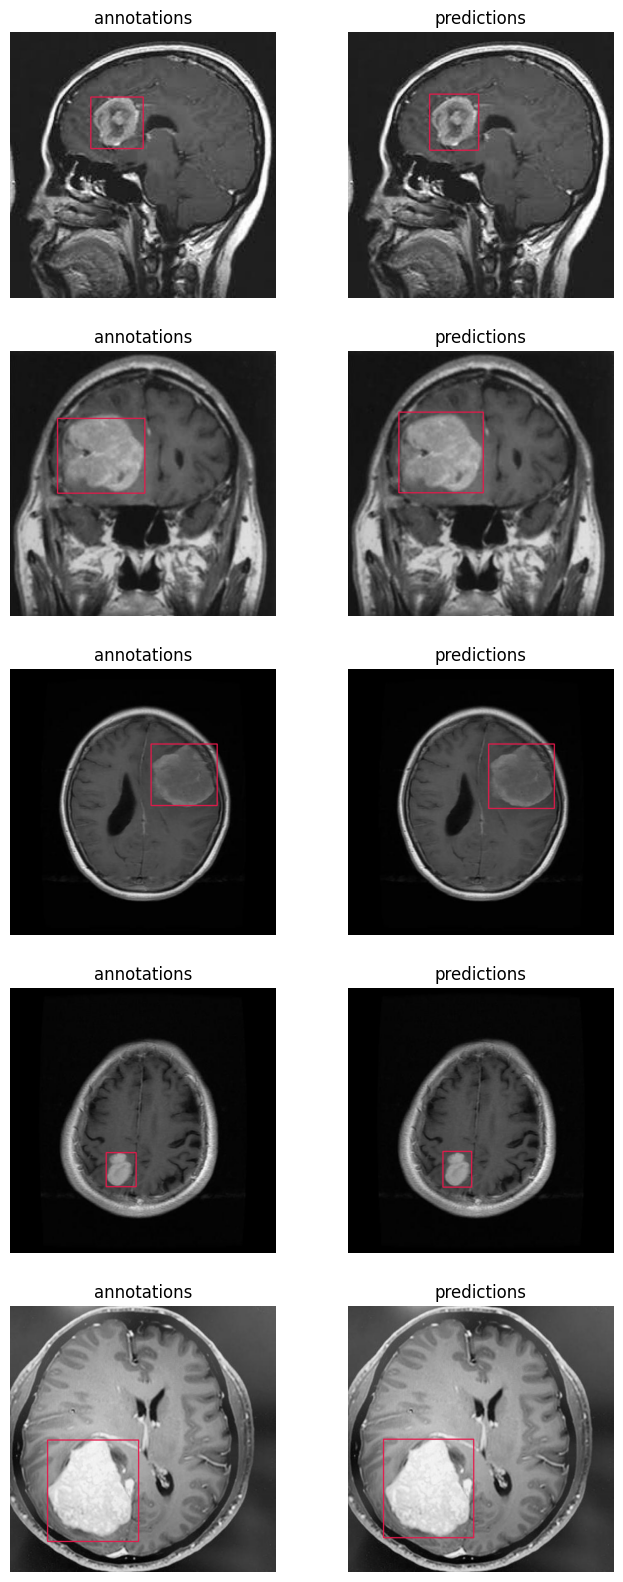

In [ ]:
import random
import supervision as sv

random.seed(10)

MAX_IMAGE_COUNT = 5

n = min(MAX_IMAGE_COUNT, len(ds.images))

keys = list(ds.images.keys())
keys = random.sample(keys, n)

box_annotator = sv.BoxAnnotator()

images = []
titles = []

for key in keys:
    frame_with_annotations = box_annotator.annotate(
        scene=ds.images[key].copy(),
        detections=ds.annotations[key],
        skip_label=True
    )
    images.append(frame_with_annotations)
    titles.append('annotations')
    frame_with_predictions = box_annotator.annotate(
        scene=ds.images[key].copy(),
        detections=predictions[key],
        skip_label=True
    )
    #checar os prints
    print(frame_with_predictions)
    images.append(frame_with_predictions)
    titles.append('predictions')

%matplotlib inline
sv.plot_images_grid(images=images, titles=titles, grid_size=(n, 2), size=(2 * 4, n * 4))

FileNotFoundError: ignored

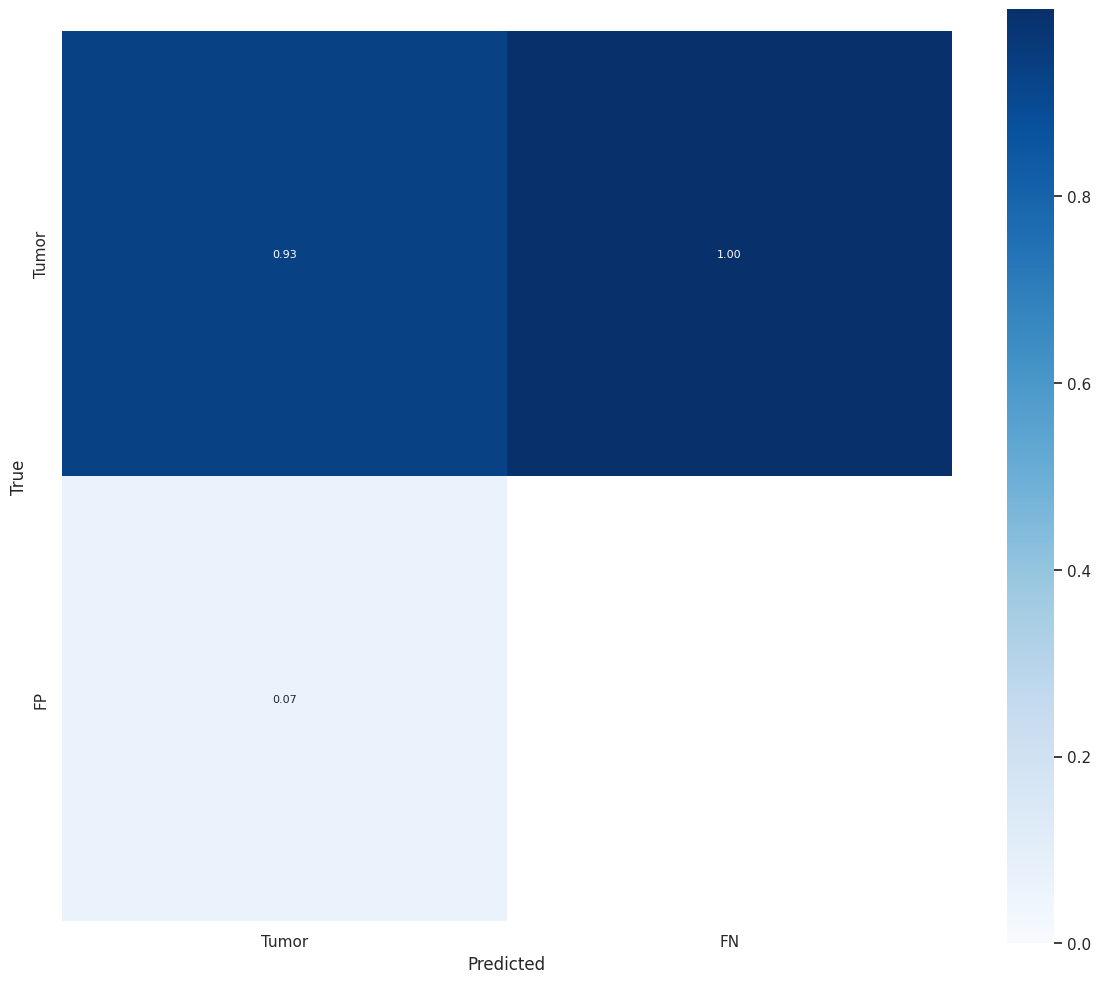

In [ ]:


import os

import numpy as np

from onemetric.cv.object_detection import ConfusionMatrix

keys = list(ds.images.keys())

annotation_batches, prediction_batches = [], []

for key in keys:
    annotation=ds.annotations[key]
    annotation_batch = np.column_stack((
        annotation.xyxy,
        annotation.class_id
    ))
    annotation_batches.append(annotation_batch)

    prediction=predictions[key]
    prediction_batch = np.column_stack((
        prediction.xyxy,
        prediction.class_id,
        prediction.confidence
    ))
    prediction_batches.append(prediction_batch)

confusion_matrix = ConfusionMatrix.from_detections(
    true_batches=annotation_batches,
    detection_batches=prediction_batches,
    num_classes=len(ds.classes),
    conf_threshold=CONFIDENCE_TRESHOLD
)

confusion_matrix.plot(os.path.join("./content", "confusion_matrix.png"), class_names=ds.classes)